In [1]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
from datetime import date
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import skew
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from scipy import stats
import utility
from scipy import stats

In [2]:
# from sklearn.datasets import make_regression
# from sklearn.model_selection import cross_validate
# from xgboost import XGBClassifier
# from sklearn.metrics import roc_auc_score, make_scorer

# def cus_scoring(y_pred, y_act):
#     score=stats.pearsonr(y_pred, y_act)[0]
#     return score

# X, y = make_regression(n_samples=200, n_features=3, noise=0.2)

# model = XGBRegressor(scale_pos_weight=9)

# scoring = {'mae' : 'neg_mean_absolute_error','mse':'neg_mean_squared_error','r square':'r2','Pearson':make_scorer(cus_scoring, greater_is_better=True)}

# # scores = cross_validate(model, X, y, scoring=make_scorer(cus_scoring, greater_is_better=True), cv=3, n_jobs=-1)
# scores = cross_validate(model, X, y, scoring=scoring, cv=3, n_jobs=-1)

# Zomato

In [3]:
# zomato only
df_zom = pd.read_csv('data/3_clean_zomato_feat_ori_sampling_train.csv')
# df_zom = pd.read_csv('data/3_jbdk_clean_zomato_feat.csv')

df_zom['rest_price_idr'] = df_zom['rest_price_idr'] / 1000
df_zom['rest_price_idr'] = df_zom['rest_price_idr'].astype(int)

# encode 
# drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac']

# ori 
drop_column = ['url','index','rating','lat','long','review']
target_column = 'rating'


# cross validation 

rf_param = {'n_estimators':500,'max_features':3, 'max_depth':30,'bootstrap':True}
xgb_param = {'n_estimators':100, 'max_depth':5, 'min_child_weight':3, 'learning_rate':0.15, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':0.1}


result_zomato_loop, result_zomato = utility.bulk_train_k_fold(df_input=df_zom, drop_column=drop_column, target_column=target_column, dataset_name='zomato_only', rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_loop['test_neg_mean_squared_error']= result_zomato_loop['test_neg_mean_squared_error']*-1
result_zomato_loop['test_neg_mean_absolute_error']= result_zomato_loop['test_neg_mean_absolute_error']*-1
result_zomato_loop['feature_size'] = len(df_zom.drop(drop_column, axis=1).columns)
result_zomato_loop['record'] = df_zom.drop(drop_column, axis=1).shape[0]
result_zomato_loop = result_zomato_loop.reset_index()

# Zomato 250 

In [4]:
# zomato geo 250
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_ori_250_sampling_train.csv')
# df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_250.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

# encode 
# drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']

# ori
drop_column = ['url','index','rating','lat','long','review','geohash','encode']

target_column = 'rating'

# cross validation
rf_param = {'n_estimators':250,'max_features':3, 'max_depth':30,'bootstrap':True}
xgb_param = {'n_estimators':100, 'max_depth':5, 'min_child_weight':1, 'learning_rate':0.15, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':0.1}

result_zomato_250_loop,  result_zomato_250  = utility.bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_250',rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_250_loop['test_neg_mean_squared_error'] = result_zomato_250_loop['test_neg_mean_squared_error']*-1
result_zomato_250_loop['test_neg_mean_absolute_error'] = result_zomato_250_loop['test_neg_mean_absolute_error']*-1
result_zomato_250_loop['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_250_loop['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]

result_zomato_250_loop = result_zomato_250_loop.reset_index()

# Zomato 500 

In [5]:
# zomato geo 500
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_ori_500_sampling_train.csv')
# df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_500.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)


# encode 
# drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']

# ori
drop_column = ['url','index','rating','lat','long','review','geohash','encode']

# cross validation
rf_param = {'n_estimators':500,'max_features':3, 'max_depth':30,'bootstrap':True}
xgb_param = {'n_estimators':100, 'max_depth':5, 'min_child_weight':3, 'learning_rate':0.2, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':0.1}

result_zomato_500_loop,  result_zomato_500 = utility.bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_500', rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_500_loop['test_neg_mean_squared_error'] = result_zomato_500_loop['test_neg_mean_squared_error']*-1
result_zomato_500_loop['test_neg_mean_absolute_error'] = result_zomato_500_loop['test_neg_mean_absolute_error']*-1
result_zomato_500_loop['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_500_loop['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]

result_zomato_500_loop = result_zomato_500_loop.reset_index()

# Zomato 1000

In [6]:
# zomato geo 1000
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_ori_1000_sampling_train.csv')
# df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_1000.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

# encode 
# drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']

# ori
drop_column = ['url','index','rating','lat','long','review','geohash','encode']
target_column = 'rating'

# cross validation
rf_param = {'n_estimators':250,'max_features':3, 'max_depth':250,'bootstrap':True}
xgb_param = {'n_estimators':1100, 'max_depth':2, 'min_child_weight':1, 'learning_rate':0.05, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':100}


result_zomato_1000_loop,  result_zomato_1000 = utility.bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_1000',rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_1000_loop['test_neg_mean_squared_error'] = result_zomato_1000_loop['test_neg_mean_squared_error']*-1
result_zomato_1000_loop['test_neg_mean_absolute_error'] = result_zomato_1000_loop['test_neg_mean_absolute_error']*-1
result_zomato_1000_loop['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_1000_loop['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]


result_zomato_1000_loop = result_zomato_1000_loop.reset_index()

In [8]:
# cross validation 
df_total_result = pd.concat([result_zomato_loop,result_zomato_250_loop, result_zomato_500_loop, result_zomato_1000_loop])

# train and test 
df_total_normal = pd.concat([result_zomato , result_zomato_250, result_zomato_500, result_zomato_1000])

In [9]:
df_total_normal

,mae,mse,pearson,name,dataset,feature_size,train_size,test_size
0,0.063502,0.010205,0.926456,rf,zomato_only,41,7496,1023
1,0.129161,0.026392,0.798468,xgb,zomato_only,41,7496,1023
2,0.159679,0.039080,0.677593,svr,zomato_only,41,7496,1023
0,0.053682,0.006880,0.952070,rf,zomato_poi_250,60,7496,1023
1,0.115785,0.021156,0.845413,xgb,zomato_poi_250,60,7496,1023
2,0.159485,0.039000,0.679161,svr,zomato_poi_250,60,7496,1023
0,0.042289,0.005048,0.964998,rf,zomato_poi_500,60,7496,1023
1,0.084178,0.011781,0.918123,xgb,zomato_poi_500,60,7496,1023
2,0.153592,0.037472,0.694516,svr,zomato_poi_500,60,7496,1023
0,0.043127,0.005439,0.962611,rf,zomato_poi_1000,60,7496,1023


In [10]:
today = date.today()
print("Today's date:", today)

Today's date: 2022-11-24


In [11]:
df_total_result.to_excel('report/ml_perform_crossval_raw_samp_{}.xlsx'.format(today),index=False)
df_total_normal.to_excel('report/ml_perform_normal_samp_{}.xlsx'.format(today),index=False)

In [12]:
df_zom_poi.drop(drop_column, axis=1).columns

Index(['rest_price_idr', 'is_chain', 'alcohol', 'delivery', 'entertainment',
       'indoor seating', 'kid friendly', 'no alcohol available',
       'others_facility', 'outdoor seating', 'parking service', 'praying room',
       'private dining area available', 'self service', 'smoking area',
       'special_meal', 'table booking', 'table booking not available',
       'table reservation required', 'takeaway available', 'asian', 'bakery',
       'beverages', 'cafe', 'coffee', 'desserts', 'drink', 'fast_food',
       'india', 'indonesia_traditional', 'indonesian', 'melayu', 'mid_east',
       'noodle', 'others_type', 'seafood', 'snacks', 'special_food',
       'street_food', 'tea', 'western', 'd_1000_airport', 'd_1000_atm',
       'd_1000_bank', 'd_1000_cafe', 'd_1000_convenience_store',
       'd_1000_gas_station', 'd_1000_hospital', 'd_1000_lodging',
       'd_1000_meal_takeaway', 'd_1000_mosque', 'd_1000_park',
       'd_1000_restaurant', 'd_1000_school', 'd_1000_store',
       'd_10

In [13]:
df_total_result.head()

,index,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2,test_Pearson,train_Pearson,name,dataset,feature_size,record
0,0,3.143451,0.177248,0.069363,-0.043253,0.011955,-0.005971,0.835465,0.913519,0.914238,0.956188,rf,zomato_only,41,8519
1,1,2.867240,0.229804,0.073789,-0.042255,0.013508,-0.005771,0.802705,0.917663,0.897243,0.958322,rf,zomato_only,41,8519
2,2,2.449069,0.152589,0.070685,-0.043376,0.012417,-0.005887,0.817965,0.915996,0.904972,0.957499,rf,zomato_only,41,8519
3,3,2.501758,0.144608,0.068209,-0.043298,0.011831,-0.005927,0.835993,0.914333,0.914697,0.956676,rf,zomato_only,41,8519
4,4,2.342714,0.149202,0.070345,-0.043451,0.011656,-0.005978,0.825942,0.915178,0.908936,0.957064,rf,zomato_only,41,8519


# Aggregate report 

In [14]:
df_total_result_agg = df_total_result.groupby(['name','dataset','feature_size']).agg({'test_neg_mean_absolute_error':['mean','std','median','var'],'test_neg_mean_squared_error':['mean','std','median','var'],'test_Pearson':['mean','std','median','var']}).reset_index()
df_total_result_agg.columns = ['name','dataset','feature_size','avg_mae','std_mae','med_mae','var_mae','avg_mse','std_mse','med_mse','var_mse','avg_pearson','std_pearson','med_pearson','var_pearson']

df_total_result_agg.to_excel('report/ml_perform_crossval_agg_samp_{}.xlsx'.format(today),index=False)

In [15]:
df_total_result_agg

,name,dataset,feature_size,avg_mae,std_mae,med_mae,var_mae,avg_mse,std_mse,med_mse,var_mse,avg_pearson,std_pearson,med_pearson,var_pearson
0,rf,zomato_only,41,0.070478,0.002087,0.070345,0.000004,0.012273,0.000745,0.011955,5.555042e-07,0.908017,0.007237,0.908936,0.000052
1,rf,zomato_poi_1000,60,0.049753,0.001157,0.049330,0.000001,0.006670,0.000250,0.006705,6.269761e-08,0.951638,0.002373,0.952204,0.000006
2,rf,zomato_poi_250,60,0.056381,0.001077,0.056230,0.000001,0.007622,0.000157,0.007594,2.452178e-08,0.944680,0.001936,0.944931,0.000004
3,rf,zomato_poi_500,60,0.049910,0.001573,0.049200,0.000002,0.006571,0.000271,0.006531,7.352017e-08,0.951850,0.003108,0.951479,0.000010
4,svr,zomato_only,41,0.165335,0.002801,0.164875,0.000008,0.041567,0.001137,0.041423,1.293673e-06,0.636471,0.011256,0.642714,0.000127
5,svr,zomato_poi_1000,60,0.126746,0.001481,0.126987,0.000002,0.027877,0.001552,0.027761,2.410000e-06,0.788340,0.014696,0.788301,0.000216
6,svr,zomato_poi_250,60,0.157516,0.004849,0.156850,0.000024,0.037632,0.002111,0.037628,4.455380e-06,0.682286,0.010942,0.675279,0.000120
7,svr,zomato_poi_500,60,0.154869,0.002422,0.154145,0.000006,0.036458,0.001449,0.036512,2.099560e-06,0.689704,0.014599,0.688232,0.000213
8,xgb,zomato_only,41,0.132979,0.001955,0.133709,0.000004,0.027699,0.001054,0.027840,1.110484e-06,0.779263,0.017310,0.786438,0.000300
9,xgb,zomato_poi_1000,60,0.134642,0.002875,0.134584,0.000008,0.026801,0.001258,0.026796,1.582728e-06,0.790945,0.008511,0.790985,0.000072


<AxesSubplot:title={'center':'Quality'}>

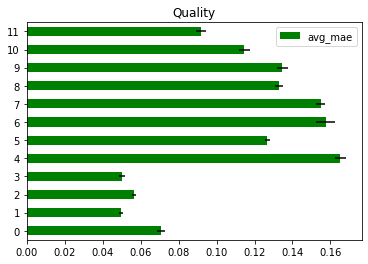

In [16]:
df_total_result_agg.plot(kind = "barh", y = "avg_mae", legend = True, xerr = "std_mae", title = "Quality", color='green')